In [2]:

# %% [Imports]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.utils import check_random_state




# Classification Analysis

This notebook covers classification using Decision Trees (ID3, CART), Naive Bayes, and Support Vector Machine (SVM). Model evaluation and comparison are included for each method.

## 1. Data Loading, Preprocessing, and Exploration

We will load the dataset, preprocess it to optimize classification performance, and visualize key aspects. Preprocessing includes handling missing values, encoding categorical variables, and scaling features. These steps are chosen to ensure models receive clean, numerical, and standardized data, which improves accuracy and comparability.

In [6]:
# %% [Data loading, pre-processing & exploration]
import time
import warnings
warnings.filterwarnings('ignore')

# Global config
RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)
plt.style.use("seaborn-v0_8")

# Sample sizes (keeping things manageable)
TEST_SIZE = 0.2
N_SPLITS = 3
SAMPLE_SIZE_FOR_GRID = 50_000   # for GridSearch tuning
SAMPLE_SIZE_FOR_SVM  = 20_000   # for SVM training (RBF kernel)

DATA_PATH = "./data/movies_dataset.csv"
TARGET = "Genre"

# ============================================================================
# Load data and create additional features
# ============================================================================
print("=" * 80)
print("DATA LOADING & FEATURE ENGINEERING")
print("=" * 80)

df = pd.read_csv(DATA_PATH)
print(f"Original dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Parse release date
df["ReleaseDate"] = pd.to_datetime(df["ReleaseDate"], dayfirst=True, errors="coerce")
df["ReleaseMonth"]   = df["ReleaseDate"].dt.month
df["ReleaseDay"]     = df["ReleaseDate"].dt.day
df["ReleaseWeekday"] = df["ReleaseDate"].dt.weekday

# Create derived features to reduce multicollinearity
df["ROI"] = df["Global_BoxOfficeUSD"] / (df["BudgetUSD"] + 1)
df["US_Share"] = df["US_BoxOfficeUSD"] / (df["Global_BoxOfficeUSD"] + 1)
df["Opening_Momentum"] = df["One_Week_SalesUSD"] / (df["Opening_Day_SalesUSD"] + 1)
df["Rating_Consensus"] = (df["IMDbRating"] / 10 + df["RottenTomatoesScore"] / 100) / 2
df["Popularity_Score"] = np.log1p(df["NumVotesIMDb"] + df["NumVotesRT"])

# Group low-frequency countries
top_countries = df['Country'].value_counts().head(9).index
df['Country_Grouped'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# ============================================================================
# Feature selection
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE SELECTION")
print("=" * 80)

# Keep only the most informative numeric features
features_num = [
    # Temporal
    "ReleaseYear", "ReleaseMonth", "ReleaseDay", "ReleaseWeekday",
    # Financial (avoid redundancy)
    "BudgetUSD", "Global_BoxOfficeUSD",
    # Sales
    "Opening_Day_SalesUSD",
    # Ratings & popularity
    "Rating_Consensus", "Popularity_Score",
    # Derived ratios
    "ROI", "US_Share", "Opening_Momentum"
]

features_cat = ["Country_Grouped"]

X_full = df[features_num + features_cat].copy()
y_full = df[TARGET].copy()

print(f"Numeric features: {len(features_num)}")
print(f"Categorical features: {len(features_cat)}")
print(f"Total features: {len(features_num) + len(features_cat)}")

# ============================================================================
# Data exploration
# ============================================================================
print("\n" + "=" * 80)
print("DATA EXPLORATION")
print("=" * 80)

print(f"\nTotal samples: {len(df):,}")
print(f"Number of classes: {y_full.nunique()}")
print(f"\nClass distribution:")
class_dist = y_full.value_counts()
for genre, count in class_dist.items():
    pct = count / len(y_full) * 100
    print(f"  {genre:15s}: {count:7,} ({pct:5.2f}%)")

print(f"\nClass balance:")
print(f"  Most frequent: {class_dist.max():,} ({class_dist.idxmax()})")
print(f"  Least frequent: {class_dist.min():,} ({class_dist.idxmin()})")
print(f"  Imbalance ratio: {class_dist.max() / class_dist.min():.2f}:1")

print(f"\nCountries after grouping: {df['Country_Grouped'].nunique()}")
print(df['Country_Grouped'].value_counts())

# ============================================================================
# Stratified sampling
# ============================================================================
print("\n" + "=" * 80)
print("STRATIFIED SAMPLING")
print("=" * 80)

def stratified_sample(X, y, n_per_class):
    """Sample data while maintaining class balance."""
    parts = []
    for cls in y.unique():
        idx = y[y == cls].index
        take = min(n_per_class, len(idx))
        sampled = rng.choice(idx, size=take, replace=False)
        parts.append(pd.DataFrame({"i": sampled}))
    sel = pd.concat(parts)["i"].values
    return X.loc[sel].copy(), y.loc[sel].copy()

# Create manageable subset for grid search
n_per_class_grid = SAMPLE_SIZE_FOR_GRID // y_full.nunique()
X_small, y_small = stratified_sample(X_full, y_full, n_per_class_grid)

print(f"Target samples per class: {n_per_class_grid:,}")
print(f"Size after sampling: {len(X_small):,}")
print(f"\nClass distribution after sampling:")
for genre, count in y_small.value_counts().items():
    print(f"  {genre:15s}: {count:,}")

# ============================================================================
# Train/test split
# ============================================================================
print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=TEST_SIZE, stratify=y_small, random_state=RANDOM_STATE
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Train classes:\n{y_train.value_counts().sort_index()}")
print(f"Test classes:\n{y_test.value_counts().sort_index()}")

# ============================================================================
# Preprocessing pipelines
# ============================================================================
print("\n" + "=" * 80)
print("PREPROCESSING PIPELINES")
print("=" * 80)

# Numeric pipeline with StandardScaler (works well with SVM)
numeric_std = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Numeric pipeline with MinMaxScaler (better for Naive Bayes)
numeric_minmax = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

# Categorical pipeline
categorical_oh = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Full preprocessing with StandardScaler
prep_std = ColumnTransformer(
    transformers=[
        ("num", numeric_std, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

# Full preprocessing with MinMaxScaler
prep_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_minmax, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

print("Preprocessor with StandardScaler ready (for SVM & Decision Trees)")
print("Preprocessor with MinMaxScaler ready (for Naive Bayes)")

# Quick test
X_train_std = prep_std.fit_transform(X_train)
print(f"\nShape after preprocessing: {X_train_std.shape}")
print(f"  Original features: {len(features_num) + len(features_cat)}")
print(f"  After One-Hot encoding: {X_train_std.shape[1]}")

# ============================================================================
# Evaluation function
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATION SETUP")
print("=" * 80)

def evaluate_model(name, model, X_te, y_te, verbose=True):
    """
    Evaluate model performance.
    
    Parameters:
        name: model name
        model: trained model (pipeline)
        X_te: test features
        y_te: test labels
        verbose: print detailed results
    
    Returns:
        dict with metrics
    """
    start = time.time()
    y_pred = model.predict(X_te)
    pred_time = time.time() - start
    
    acc = accuracy_score(y_te, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    
    if verbose:
        print(f"\n{'=' * 80}")
        print(f"{name}")
        print(f"{'=' * 80}")
        metrics_df = pd.DataFrame({
            "Metric": ["Accuracy", "Precision (macro)", "Recall (macro)", "F1-Score (macro)", "Prediction time"],
            "Value": [f"{acc:.4f}", f"{pr:.4f}", f"{rc:.4f}", f"{f1:.4f}", f"{pred_time:.3f}s"]
        })
        print(metrics_df.to_string(index=False))
        
        print(f"\nConfusion Matrix:")
        cm = confusion_matrix(y_te, y_pred)
        cm_df = pd.DataFrame(cm, 
                             index=[f"True_{c}" for c in sorted(y_te.unique())],
                             columns=[f"Pred_{c}" for c in sorted(y_te.unique())])
        print(cm_df)
        
        print(f"\nClassification Report:")
        print(classification_report(y_te, y_pred, zero_division=0))
    
    return {
        "model": name, 
        "accuracy": acc, 
        "precision_macro": pr, 
        "recall_macro": rc, 
        "f1_macro": f1,
        "prediction_time": pred_time
    }

print("Evaluation function ready")

print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE")
print("=" * 80)
print("Ready to train models!")

DATA LOADING & FEATURE ENGINEERING
Original dataset: 999,999 rows, 17 columns

FEATURE SELECTION
Numeric features: 12
Categorical features: 1
Total features: 13

DATA EXPLORATION

Total samples: 999,999
Number of classes: 8

Class distribution:
  Drama          : 250,018 (25.00%)
  Comedy         : 199,832 (19.98%)
  Action         : 150,131 (15.01%)
  Thriller       : 100,071 (10.01%)
  Romance        : 100,021 (10.00%)
  Horror         : 100,010 (10.00%)
  Documentary    :  50,114 ( 5.01%)
  Sci-Fi         :  49,802 ( 4.98%)

Class balance:
  Most frequent: 250,018 (Drama)
  Least frequent: 49,802 (Sci-Fi)
  Imbalance ratio: 5.02:1

Countries after grouping: 10
Country_Grouped
USA          714581
UK            51277
India         50984
Canada        40528
China         30952
Australia     30587
France        30471
Japan         20222
Germany       20211
Other         10186
Name: count, dtype: int64

STRATIFIED SAMPLING
Target samples per class: 6,250
Size after sampling: 50,000

Clas

## 3. Decision Trees (ID3 & CART)

We will train and evaluate Decision Tree classifiers using both ID3 (entropy) and CART (gini) criteria.

ID3 (entropía)

In [51]:

# %% [Decision Trees - ID3 (entropía)]
from collections import Counter
from dataclasses import dataclass

def entropy(y):
    counts = np.array(list(Counter(y).values()), dtype=float)
    p = counts / counts.sum()
    p = p[p > 0]
    return -(p * np.log2(p)).sum()

def information_gain(y, splits):
    H_parent = entropy(y)
    n = len(y)
    H_children = 0.0
    for idx in splits:
        child = y[idx] if isinstance(idx, np.ndarray) else y.iloc[idx]
        w = (child.size if hasattr(child, 'size') else len(child)) / n
        if len(child) > 0:
            H_children += w * entropy(child)
    return H_parent - H_children

@dataclass
class Node:
    feature: str = None
    threshold: float = None
    branches: dict = None
    left: 'Node' = None
    right: 'Node' = None
    label: any = None

class ID3:
    def __init__(self, max_depth=None, min_samples_split=2, min_gain=1e-9):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.tree_ = None
        self.classes_ = None

    def fit(self, X_df: pd.DataFrame, y: pd.Series):
        X = X_df.copy()
        # imputación simple
        for c in X.columns:
            if pd.api.types.is_numeric_dtype(X[c]):
                X[c] = X[c].fillna(X[c].median())
            else:
                X[c] = X[c].fillna(X[c].mode().iloc[0]).astype("category")
        self.classes_ = np.unique(y)
        self.tree_ = self._grow(X, y, 0)
        return self

    def _majority(self, y): return Counter(y).most_common(1)[0][0]

    def _best_split_numeric(self, x, y):
        order = np.argsort(x)
        x_sorted, y_sorted = x[order], y[order]
        uniq = np.unique(x_sorted)
        if uniq.size <= 1: return None, -np.inf
        thr_candidates = (uniq[:-1] + uniq[1:]) / 2.0
        best_gain, best_thr = -np.inf, None
        for thr in thr_candidates:
            left_mask = x <= thr
            right_mask = ~left_mask
            gain = information_gain(y, [left_mask, right_mask])
            if gain > best_gain:
                best_gain, best_thr = gain, thr
        return best_thr, best_gain

    def _grow(self, X, y, depth):
        if len(np.unique(y)) == 1: return Node(label=y.iloc[0])
        if self.max_depth is not None and depth >= self.max_depth: return Node(label=self._majority(y))
        if len(X) < self.min_samples_split or X.shape[1] == 0: return Node(label=self._majority(y))

        best_feature, best_gain, best_split, best_kind = None, -np.inf, None, None
        for feat in X.columns:
            col = X[feat]
            if pd.api.types.is_numeric_dtype(col):
                thr, gain = self._best_split_numeric(col.values, y.values)
                if thr is not None and gain > best_gain:
                    best_feature, best_gain, best_split, best_kind = feat, gain, thr, "num"
            else:
                cats = col.astype("category").cat.categories
                splits = [(col == cat).values for cat in cats]
                gain = information_gain(y.values, splits)
                if gain > best_gain:
                    best_feature, best_gain, best_split, best_kind = feat, gain, cats, "cat"

        if best_gain < self.min_gain or best_feature is None:
            return Node(label=self._majority(y))

        if best_kind == "num":
            thr = best_split
            node = Node(feature=best_feature, threshold=thr)
            left_mask = X[best_feature] <= thr
            right_mask = ~left_mask
            node.left  = self._grow(X[left_mask],  y[left_mask],  depth+1)
            node.right = self._grow(X[right_mask], y[right_mask], depth+1)
            return node
        else:
            cats = best_split
            node = Node(feature=best_feature, branches={})
            for cat in cats:
                mask = X[best_feature] == cat
                node.branches[cat] = self._grow(X[mask], y[mask], depth+1) if mask.sum() > 0 else Node(label=self._majority(y))
            return node

    def _predict_row(self, row, node: Node):
        while node.label is None:
            val = row.get(node.feature, None)
            if node.threshold is not None:
                node = node.left if val <= node.threshold else node.right
            else:
                node = node.branches.get(val, Node(label=self.classes_[0]))
        return node.label

    def predict(self, X_df: pd.DataFrame):
        return np.array([self._predict_row(row, self.tree_) for _, row in X_df.iterrows()])

# Entrenar ID3 sobre X_train (ya preprocesado simple en fit)
id3 = ID3(max_depth=None, min_samples_split=2, min_gain=1e-9)
id3.fit(X_train, y_train)

# Evaluación ID3
res_id3 = evaluate_model("ID3 (from-scratch)", id3, X_test, y_test)



== ID3 (from-scratch) ==
accuracy           0.128100
precision_macro    0.128081
recall_macro       0.128100
f1_macro           0.128080
dtype: float64

Matriz de confusión:
 [[149 177 139 161 179 131 165 149]
 [146 167 143 164 149 149 167 165]
 [162 166 156 139 159 156 149 163]
 [133 142 153 184 156 152 167 163]
 [158 156 170 141 162 137 157 169]
 [163 156 150 159 173 157 142 150]
 [162 159 160 147 141 172 147 162]
 [163 152 144 159 155 171 147 159]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.12      0.12      0.12      1250
      Comedy       0.13      0.13      0.13      1250
 Documentary       0.13      0.12      0.13      1250
       Drama       0.15      0.15      0.15      1250
      Horror       0.13      0.13      0.13      1250
     Romance       0.13      0.13      0.13      1250
      Sci-Fi       0.12      0.12      0.12      1250
    Thriller       0.12      0.13      0.13      1250

    accuracy                      

CART (Criterion = gini)

In [49]:
# %% [Decision Trees - CART (sklearn)]
cart_pipe = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", DecisionTreeClassifier(criterion="gini", random_state=RANDOM_STATE))
])

grid_cart = {
    "clf__max_depth": [None, 8, 12],
    "clf__min_samples_split": [2, 10],
    "clf__min_samples_leaf": [1, 3],
    "clf__ccp_alpha": [0.0, 0.001]
}

scoring = {"f1_macro": "f1_macro", "accuracy": "accuracy"}
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

gs_cart = GridSearchCV(
    estimator=cart_pipe, param_grid=grid_cart,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_cart.fit(X_train, y_train)

print("\n[CART] mejores params:", gs_cart.best_params_)
print("[CART] CV mean scores:", {m: gs_cart.cv_results_[f"mean_test_{m}"][gs_cart.best_index_] for m in scoring})

# Evaluación CART
best_cart = gs_cart.best_estimator_
res_cart = evaluate_model("CART (sklearn)", best_cart, X_test, y_test)


[CART] mejores params: {'clf__ccp_alpha': 0.0, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
[CART] CV mean scores: {'f1_macro': 0.12599193916318224, 'accuracy': 0.12629994578423032}

== CART (sklearn) ==
accuracy           0.126200
precision_macro    0.126566
recall_macro       0.126200
f1_macro           0.126003
dtype: float64

Matriz de confusión:
 [[179 195 165 144 139 145 139 144]
 [193 182 157 150 132 151 154 131]
 [196 158 149 171 147 157 144 128]
 [204 176 174 156 135 146 135 124]
 [189 164 169 173 157 141 139 118]
 [163 157 171 180 141 158 150 130]
 [190 158 172 152 148 150 153 127]
 [194 173 165 148 148 140 154 128]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.12      0.14      0.13      1250
      Comedy       0.13      0.15      0.14      1250
 Documentary       0.11      0.12      0.12      1250
       Drama       0.12      0.12      0.12      1250
      Horror       0.14      0.13  

## 4. Naive Bayes

Train and evaluate a Naive Bayes classifier.

In [36]:

# GaussianNB (para continuas)
nb_gaussian = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", GaussianNB())
])

# MultinomialNB (requiere no-negatividad; MinMax ayuda)
nb_mult = Pipeline(steps=[
    ("prep", prep_minmax),
    ("clf", MultinomialNB())
])

# Pequeño grid para Multinomial
grid_nb_mult = {"clf__alpha": [0.0, 0.5, 1.0]}

gs_nb_mult = GridSearchCV(
    estimator=nb_mult, param_grid=grid_nb_mult,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_nb_mult.fit(X_train, y_train)

print("\n[NB-Mult] mejores params:", gs_nb_mult.best_params_)
print("[NB-Mult] CV mean scores:", {m: gs_nb_mult.cv_results_[f"mean_test_{m}"][gs_nb_mult.best_index_] for m in scoring})

# Entrena GaussianNB (sin grid)
nb_gaussian.fit(X_train, y_train)

# Evalúa ambos y elige mejor por F1 macro
res_nbG = evaluate_model("Naive Bayes (Gaussian)", nb_gaussian, X_test, y_test)
res_nbM = evaluate_model("Naive Bayes (Multinomial)", gs_nb_mult.best_estimator_, X_test, y_test)

best_nb_res = res_nbM if res_nbM["f1_macro"] >= res_nbG["f1_macro"] else res_nbG
best_nb_name = best_nb_res["model"]
print(f"\n[NB] Mejor variante: {best_nb_name}")



[NB-Mult] mejores params: {'clf__alpha': 0.0}
[NB-Mult] CV mean scores: {'f1_macro': 0.09664652087151866, 'accuracy': 0.12437502140493366}

== Naive Bayes (Gaussian) ==
accuracy           0.129400
precision_macro    0.136299
recall_macro       0.129400
f1_macro           0.081846
dtype: float64

Matriz de confusión:
 [[141  69  41  15  46 873  18  47]
 [131  87  48   9  61 858  16  40]
 [127  73  46   8  53 893  16  34]
 [125  88  44  19  45 878  17  34]
 [130  80  48  11  52 853  28  48]
 [119  64  47   9  50 892  19  50]
 [136  69  47   9  55 884  12  38]
 [136  70  32  12  56 889  10  45]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.13      0.11      0.12      1250
      Comedy       0.14      0.07      0.09      1250
 Documentary       0.13      0.04      0.06      1250
       Drama       0.21      0.02      0.03      1250
      Horror       0.12      0.04      0.06      1250
     Romance       0.13      0.71      0.22      1250

## 5. Support Vector Machine (SVM)

Train and evaluate a Support Vector Machine classifier.

In [53]:

# SVM es costoso. Submuestreo adicional para entrenar con tiempos razonables
n_per_class_svm = SAMPLE_SIZE_FOR_SVM // y_train.nunique()
X_svm_train, y_svm_train = stratified_sample(X_train, y_train, n_per_class_svm)

svm_pipe = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=RANDOM_STATE))
])

grid_svm = {
    "clf__C": [1, 5, 10],
    "clf__gamma": ["scale", 0.1]
}

gs_svm = GridSearchCV(
    estimator=svm_pipe, param_grid=grid_svm,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_svm.fit(X_svm_train, y_svm_train)

print("\n[SVM] mejores params:", gs_svm.best_params_)
print("[SVM] CV mean scores:", {m: gs_svm.cv_results_[f"mean_test_{m}"][gs_svm.best_index_] for m in scoring})

# Evaluación SVM en X_test completo (preprocesado dentro del pipeline)
best_svm = gs_svm.best_estimator_
res_svm = evaluate_model("SVM (RBF)", best_svm, X_test, y_test)



[SVM] mejores params: {'clf__C': 5, 'clf__gamma': 'scale'}
[SVM] CV mean scores: {'f1_macro': 0.1273560941034949, 'accuracy': 0.12864992813965662}

== SVM (RBF) ==
accuracy           0.123400
precision_macro    0.123733
recall_macro       0.123400
f1_macro           0.121705
dtype: float64

Matriz de confusión:
 [[162 156 228 218 112 147 103 124]
 [167 140 227 215 110 149 121 121]
 [184 168 219 178 114 167 109 111]
 [170 139 207 215 115 158 106 140]
 [180 151 197 210 121 154 122 115]
 [173 150 210 224 135 135 121 102]
 [170 129 241 188 122 163 123 114]
 [196 126 208 222 100 161 118 119]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.12      0.13      0.12      1250
      Comedy       0.12      0.11      0.12      1250
 Documentary       0.13      0.18      0.15      1250
       Drama       0.13      0.17      0.15      1250
      Horror       0.13      0.10      0.11      1250
     Romance       0.11      0.11      0.11      1250
    

## 6. Model Comparison

Compare the performance of all classifiers using accuracy and classification metrics.


=== COMPARATIVA (ordenado por F1_macro) ===
                            accuracy  precision_macro  recall_macro  f1_macro
model                                                                       
ID3 (from-scratch)           0.1281         0.128081        0.1281  0.128080
CART (sklearn)               0.1262         0.126566        0.1262  0.126003
SVM (RBF)                    0.1244         0.124997        0.1244  0.123396
Naive Bayes (Multinomial)    0.1253         0.111565        0.1253  0.097355


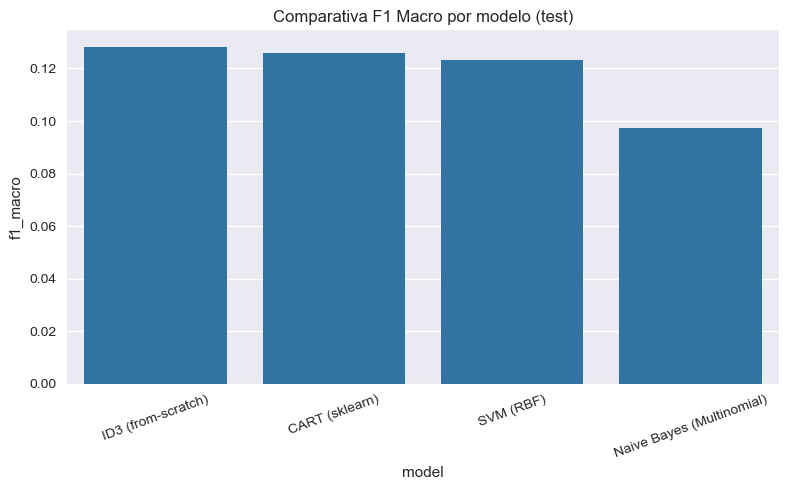

In [52]:

# %% [Comparativa final]
results = [res_cart, best_nb_res, res_svm, res_id3]
df_res = pd.DataFrame(results).set_index("model").sort_values("f1_macro", ascending=False)
print("\n=== COMPARATIVA (ordenado por F1_macro) ===\n", df_res)

# Guardar resultados a CSV (opcional)
df_res.to_csv("classification_results.csv", index=True)

# (Opcional) gráfico rápido de F1 macro
plt.figure(figsize=(8,5))
sns.barplot(x=df_res.index, y=df_res["f1_macro"], color="#1f77b4")
plt.title("Comparativa F1 Macro por modelo (test)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
